# Function optimize_ga with *moments* for (YRI, CEU) inference

It is example from [moments](https://bitbucket.org/simongravel/moments/). In original example close to optimal parameters are pertrubed and then local search (optimize_log, optimize_powell etc.) is launched.

In our modification of this example here we use global search - Genetic Algorithm (optimize_ga) from [GADMA](https://github.com/ctlab/GADMA) software.

You can find original python code [here](https://bitbucket.org/simongravel/moments/src/master/examples/YRI_CEU/YRI_CEU.py) (`moments/examples/YRI_CEU/YRI_CEU.py` file)

## Imports

In [1]:
import moments
import gadma
%matplotlib inline

## Data

Data was build originally for paper [Gutenkunst et al. 2009](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000695).

It is 20x20 spectrum for two populations:

* YRI - Yoruba in Ibadan, Nigeria
* CEU - Utah Residents (CEPH) with Northern and Western European Ancestry

In [2]:
data = moments.Spectrum.from_file("YRI_CEU.fs")
ns = data.sample_sizes
print(f"Size of spectrum: {ns}")

Size of spectrum: [20 20]


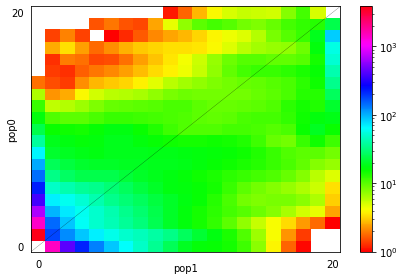

In [3]:
moments.Plotting.plot_single_2d_sfs(data, vmin=1.0)

## Demographic model

Demographic model is saved in `demographic_models_moments.py` as ``model_func`` function. But we also put it here:

In [4]:
import numpy
import moments

def model_func(params, ns):
    """
    Model with growth, split, bottleneck in pop2, exp recovery, migration

    nu1F: The ancestral population size after growth. (Its initial size is
          defined to be 1.)
    nu2B: The bottleneck size for pop2
    nu2F: The final size for pop2
    m: The scaled migration rate
    Tp: The scaled time between ancestral population growth and the split.
    T: The time between the split and present

    n1,n2: Size of fs to generate.
    pts: Number of points to use in grid for evaluation.
    """

    nu1F, nu2B, nu2F, m, Tp, T = params
    # f for the equilibrium ancestral population
    sts = moments.LinearSystem_1D.steady_state_1D(ns[0]+ns[1])
    fs = moments.Spectrum(sts)

    
    # Now do the population growth event.
    fs.integrate([nu1F], Tp)
    # The divergence
    fs = moments.Manips.split_1D_to_2D(fs, ns[0], ns[1])
    # We need to define a function to describe the non-constant population 2
    # size. lambda is a convenient way to do so.
    nu2_func = lambda t: [nu1F, nu2B*(nu2F/nu2B)**(t/T)]
    fs.integrate(nu2_func, T, m=numpy.array([[0, m],[m, 0]]))

    return fs

We can import it from file by:

In [5]:
from demographic_models_moments import model_func as func

or use directly from our notebook:

In [6]:
func = model_func

## Inference

Now we will infer parameters for this demographic history and loaded data.

In [7]:
# Now let's optimize parameters for this model.

# The upper_bound and lower_bound lists are for use in optimization.
# Occasionally the optimizer will try wacky parameter values. We in particular
# want to exclude values with very long times, very small population sizes, or
# very high migration rates, as they will take a long time to evaluate.
# Parameters are: (nu1F, nu2B, nu2F, m, Tp, T)
par_labels = ('nu1F', 'nu2B', 'nu2F', 'm', 'Tp', 'T')
upper_bound = [100, 100, 100, 10, 3, 3]
lower_bound = [1e-2, 1e-2, 1e-2, 0, 0, 0]

# Run our optimization
# For more information: help(gadma.Inference.optimize_ga)
# It is test optimization so only 10 iterations of global optimization
# (ga_maxiter) and 1 iteration of local (ls_maxiter) are run.
# For better optimization set those number to greater values or to None.
print('Beginning optimization ************************************************')
result = gadma.Inference.optimize_ga(data=data,
                                     model_func=func,
                                     engine='moments',
                                     args=(),
                                     p_ids = par_labels,
                                     lower_bound=lower_bound,
                                     upper_bound=upper_bound,
                                     local_optimizer='BFGS_log',
                                     ga_maxiter=10,
                                     ls_maxiter=1)
print('Finshed optimization **************************************************')

Beginning optimization ************************************************
--Start global optimization Genetic_algorithm--
Generation #0.
Current generation of solutions:
N	Value of fitness function	Solution
0	-1987.052205	(nu1F=3.43862,	nu2B=2.89219,	nu2F=1.27423,	m=0.73591,	Tp=0.72851,	T=1.64976)	r
1	-2234.646741	(nu1F=3.50412,	nu2B=0.13566,	nu2F=0.34019,	m=1.39445,	Tp=0.6516,	T=1.26159)	r
2	-3284.832003	(nu1F=2.36307,	nu2B=10.48031,	nu2F=0.15888,	m=0.90435,	Tp=1.40333,	T=0.77398)	r
3	-3949.781543	(nu1F=27.61818,	nu2B=1.91526,	nu2F=0.37061,	m=1.48645,	Tp=0.77768,	T=1.62237)	r
4	-4094.822922	(nu1F=6.88753,	nu2B=0.53698,	nu2F=4.57133,	m=0.742,	Tp=0.51412,	T=1.22419)	r
5	-4471.930371	(nu1F=6.58858,	nu2B=0.20111,	nu2F=0.25936,	m=1.01793,	Tp=1.33963,	T=1.05038)	r
6	-4482.327581	(nu1F=2.07049,	nu2B=3.27477,	nu2F=4.70106,	m=0,	Tp=0.43373,	T=0.24935)	r
7	-4566.605335	(nu1F=8.27895,	nu2B=4.02306,	nu2F=2.46973,	m=0.60475,	Tp=1.18486,	T=0.79746)	r
8	-4627.880832	(nu1F=3.15245,	nu2B=4.30329,	nu2F=2

Generation #7.
Current generation of solutions:
N	Value of fitness function	Solution
0	-1523.930595	(nu1F=3.43862,	nu2B=0.0472,	nu2F=0.94865,	m=1.06699,	Tp=0.89919,	T=1.64976)	m
1	-1597.687926	(nu1F=3.43862,	nu2B=0.0472,	nu2F=1.27423,	m=1.06699,	Tp=0.89919,	T=1.64976)	c
2	-1663.525411	(nu1F=3.43862,	nu2B=1.24507,	nu2F=1.27423,	m=0.73591,	Tp=0.72851,	T=1.64976)	c
3	-1790.894462	(nu1F=3.43862,	nu2B=0.10516,	nu2F=1.27423,	m=1.39445,	Tp=0.72851,	T=0.76911)	m
4	-2515.310931	(nu1F=3.43862,	nu2B=5.27405,	nu2F=1.27423,	m=0.73591,	Tp=0.72851,	T=1.05955)	c
5	-2993.586871	(nu1F=3.43862,	nu2B=0.10516,	nu2F=2.24041,	m=1.39445,	Tp=0.50409,	T=1.26159)	c
6	-4321.808193	(nu1F=3.43862,	nu2B=1.24507,	nu2F=0.24297,	m=0.73591,	Tp=0.90613,	T=1.64976)	c
7	-30626.942399	(nu1F=0.04939,	nu2B=3.09023,	nu2F=1.13642,	m=0.8169,	Tp=1.70968,	T=1.21844)	mmm
8	-35323.431586	(nu1F=0.92815,	nu2B=0.2353,	nu2F=0.48838,	m=0,	Tp=1.00142,	T=1.40864)	r
9	-164418.367383	(nu1F=0.03477,	nu2B=1.40775,	nu2F=0.87201,	m=0,	Tp=0.73566

In [8]:
popt = result.x
print(f'Found parameters: {popt}')
print(f'With log-likelihood: {result.y}')

# Now we can compare our parameters with those that were obtained before:
print('\nFrom Gutenkunst et al 2009:')
# These are the actual best-fit model parameters, which we found through
# longer optimizations and confirmed by running multiple optimizations.
# We'll work with them through the rest of this script. 
popt = [1.881, 0.0710, 1.845, 0.911, 0.355, 0.111]
print('Best-fit parameters: {0}'.format(popt))

# Calculate the best-fit model AFS.
model = func(popt, ns)
# Likelihood of the data given the model AFS.
ll_model = moments.Inference.ll_multinom(model, data)
print('Maximum log composite likelihood: {0}'.format(ll_model))
# The optimal value of theta given the model.
theta = moments.Inference.optimal_sfs_scaling(model, data)
print('Optimal value of theta: {0}'.format(theta))

Found parameters: [3.147213338395963 0.11024832837019047 1.3161713345388721
 0.9323024229304987 1.7659504105567985 1.3143963844420017]
With log-likelihood: -1348.6547333289695

From Gutenkunst et al 2009:
Best-fit parameters: [1.881, 0.071, 1.845, 0.911, 0.355, 0.111]
Maximum log composite likelihood: -1066.8225223685229
Optimal value of theta: 2742.0151382905815


## Plotting

Now we could draw some plots for model with best parameters.

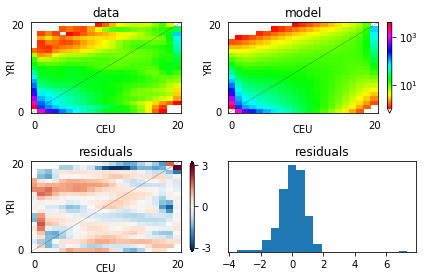

In [9]:
# Plot a comparison of the resulting fs with the data.
import pylab
pylab.figure(1)
moments.Plotting.plot_2d_comp_multinom(model, data, vmin=1, resid_range=3,
                                    pop_ids =('YRI','CEU'), show=True)

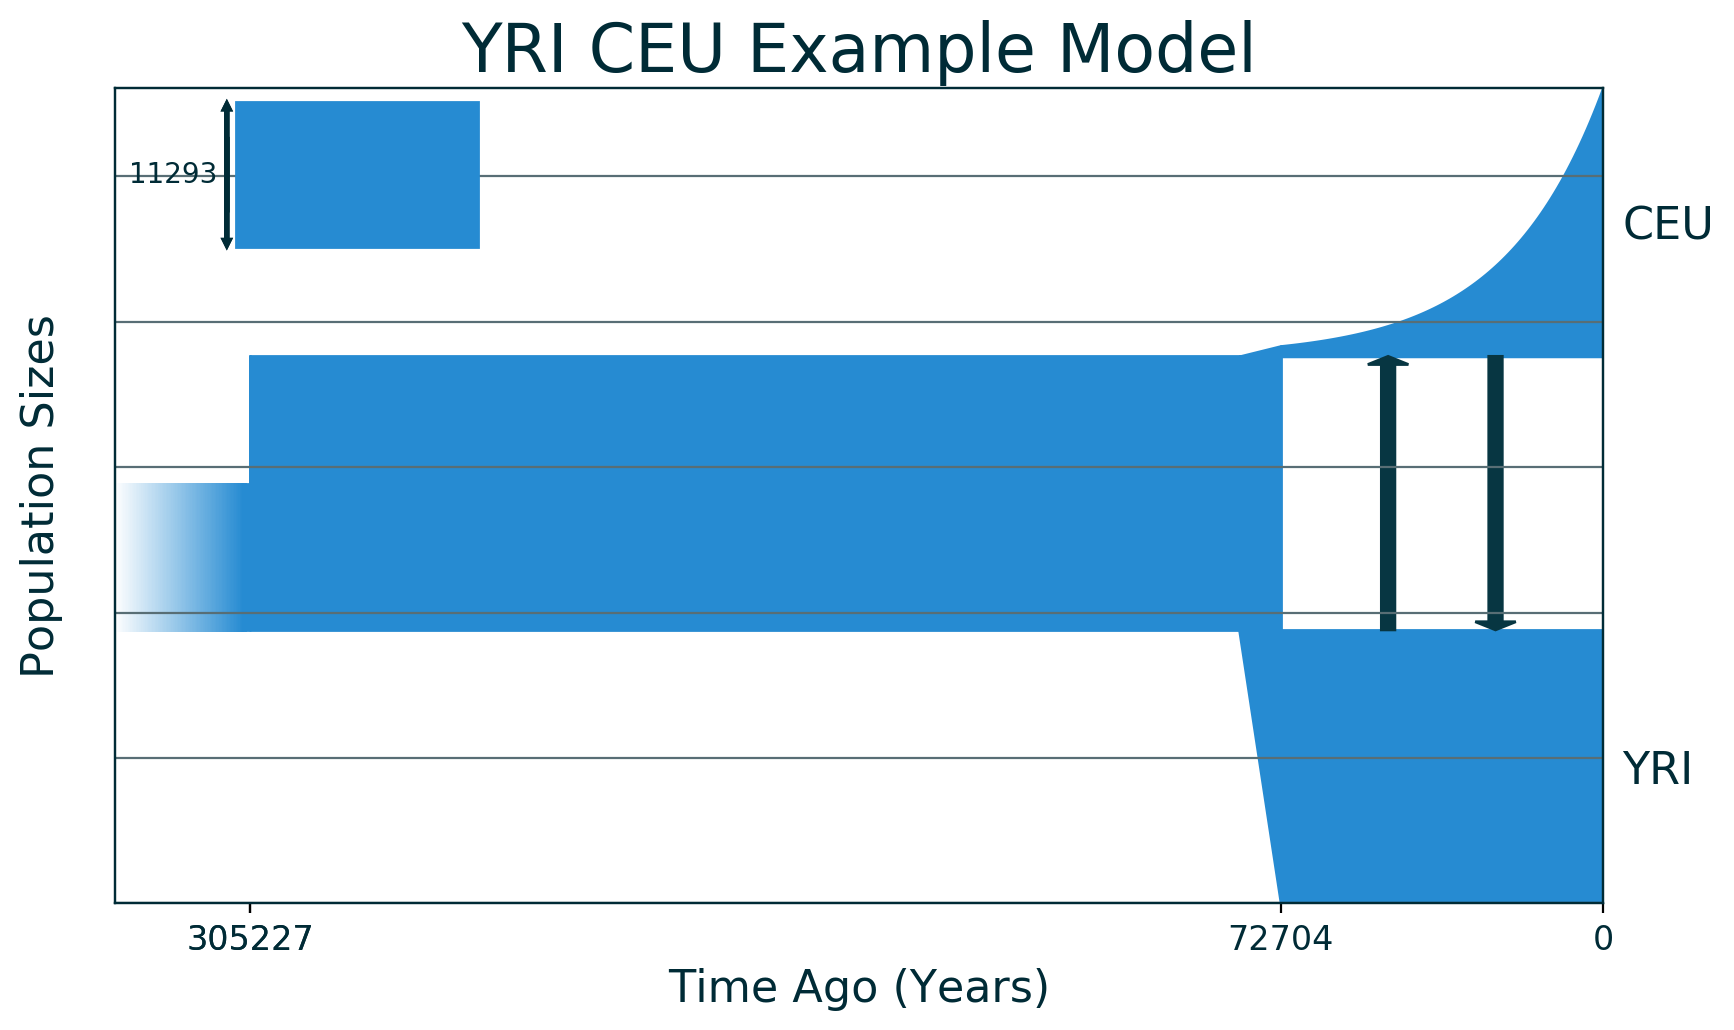

In [10]:
# Now that we've found the optimal parameters, we can use ModelPlot to
# automatically generate a graph of our determined model.

# First we generate the model by passing in the demographic function we used,
# and the optimal parameters determined for it.
model = moments.ModelPlot.generate_model(func, popt, ns)

# Next, we plot the model. See ModelPlot.py for more information on the various
# parameters that can be passed to the plotting function. In this case, we scale
# the model to have an original starting population of size 11293 and a
# generation time of 29 years. Results are saved to YRI_CEU_model.png.
moments.ModelPlot.plot_model(
    model,
    save_file=None,
    fig_title="YRI CEU Example Model",
    pop_labels=["YRI", "CEU"],
    nref=11293,
    gen_time=29.0,
    gen_time_units="Years",
    reverse_timeline=True,
)